# <font color = white > **Stochastic Simulation (5284STSI6Y) | MSc Computational Science at UvA** </font>

# <font color = #DE3163 > **Assignment 1: Mandelbrot Set** </font>
*By Victor Piaskowski(15132625), Sanjhana Bhusal (14724383), and Lisa Pahladsingh(13846566)*

In [30]:
# Standard library imports
from statistics import mean, stdev, variance 
import warnings

# Related third party imports
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import colorsys
import random
import time
import scipy.stats as stats
import math
from numba import jit

warnings.simplefilter("ignore")

### <font color = LightCoral> **EXERCISE 1** </font>

#### <font color = Gray> ***Visualisation of Mandelbrot*** </font>

In [31]:
# Constants
image_width = 1000  
x_center = -0.65  
y_center = 0  
x_range = 3.4 
aspect_ratio = 4/3  

precision = 500  # Number of iterations to determine if a point is in the Mandelbrot set

# Derived constants
image_height = round(image_width / aspect_ratio)  
y_range = x_range / aspect_ratio  
min_x = x_center - x_range / 2  
max_x = x_center + x_range / 2
min_y = y_center - y_range / 2
max_y = y_center + y_range / 2

def power_color(distance, exp, const, scale):
    """
    Generates a color based on the distance to the set.
    
    Args:
        distance (float): Normalized iteration count.
        exp (float): Exponent for scaling the distance.
        const (float): Constant factor for hue.
        scale (float): Scale factor for hue.

    Returns:
        tuple: RGB color.
    """
    color = distance**exp
    rgb = colorsys.hsv_to_rgb(const + scale * color, 1 - 0.6 * color, 0.9)
    return tuple(round(i * 255) for i in rgb)

def generate_fractal(width, height, min_x, max_x, min_y, max_y, precision):
    """
    Generates and saves an image of the Mandelbrot set.

    Args:
        width (int): Width of the image.
        height (int): Height of the image.
        min_x (float): Minimum x-value.
        max_x (float): Maximum x-value.
        min_y (float): Minimum y-value.
        max_y (float): Maximum y-value.
        precision (int): Iteration count for the Mandelbrot set calculation.

    Returns:
        None: The image is saved directly to a file.
    """
    img = Image.new('RGB', (width, height), color='black')
    pixels = img.load()

    for row in range(height):
        for col in range(width):
            x = min_x + col * (max_x - min_x) / width
            y = max_y - row * (max_y - min_y) / height
            old_x, old_y = x, y
            for i in range(precision + 1):
                a = x*x - y*y  # Real component of z^2
                b = 2 * x * y  # Imaginary component of z^2
                x = a + old_x  # Real component of new z
                y = b + old_y  # Imaginary component of new z
                if x*x + y*y > 4:  # Check if the point escapes the Mandelbrot set
                    break
            if i < precision:
                distance = (i + 1) / (precision + 1)
                rgb = power_color(distance, 0.2, 0.35, 1.0)
                pixels[col, row] = rgb

    img.save('output.png')  # Save the generated image

# Generate the fractal image
generate_fractal(image_width, image_height, min_x, max_x, min_y, max_y, precision)


### <font color = LightCoral> **EXERCISE 3** </font>

#### <font color = Gray> ***Different Sampling Methods*** </font>

In [26]:
def random_sampling(xmin, xmax, ymin, ymax, pixeldensity, samples, antithetic=False):
    """randomly creates points within the mandelbrot set to be tested

    Args:
        xmin (float): min value of x axis for mandelbrot set
        xmax (float): max value of x axis for mandelbrot set
        ymin (float): min value of y axis for mandelbrot set
        ymax (float): max value of y axis for mandelbrot set
        pixeldensity (int): number of pixels for image
        samples (int): number of samples to take

    Returns:
        list: returns list cosnisting of random x and y points, and the same points scaled to the image dimensions to be plotted on the mandelbrot set image
    """
    
    random_x_axis = []
    random_y_axis = []
    random_x_axis_plotted = []
    random_y_axis_plotted = []

    iteration = 0
    while (iteration < samples):
        random_x = random.uniform(xmin, xmax)
        random_y = random.uniform(ymin, ymax)
        if not antithetic:

            #U distribution
            random_x_axis.append(random_x)
            random_y_axis.append(random_y)

            random_x_axis_plotted.append((random_x + abs(xmin)) * pixeldensity)
            random_y_axis_plotted.append((random_y + abs(ymin)) * pixeldensity)
            iteration += 1

        else:
            # 1- U distribution 
            random_x = (xmin + xmax) - random_x
            random_y = (ymin + ymax) - random_y

            random_x_axis.append(random_x)
            random_y_axis.append(random_y)
            random_x_axis_plotted.append((random_x + abs(xmin)) * pixeldensity)
            random_y_axis_plotted.append((random_y + abs(ymin)) * pixeldensity)
            iteration += 1
            
    return random_x_axis, random_y_axis, random_x_axis_plotted, random_y_axis_plotted

def latin_hypercube_sampling(xmin, xmax, ymin, ymax, pixeldensity, samples):
    """creates a grid of samples*samples size grid and randomly samples from each row and column to create a latin hypercube

    Args:
        xmin (float): min value of x axis for mandelbrot set
        xmax (float): max value of x axis for mandelbrot set
        ymin (float): min value of y axis for mandelbrot set
        ymax (float): max value of y axis for mandelbrot set
        pixeldensity (int): number of pixels for image 
        samples (int): number of samples to take, namely how large the grid will be

    Returns:
        list: returns 4 lists of equal size, the x and y points of the randomly selected latin hypercube points and the x and y points of the latin hypercube scaled to the image dimensions
    """
    x_points = np.linspace(xmin, xmax, samples+1)
    y_points = np.linspace(ymin, ymax, samples+1)

    bin_size = x_points[1] - x_points[0]

    random_x_axis = []
    random_y_axis = []
    random_x_axis_plotted = []
    random_y_axis_plotted = []

    while (y_points.shape[0] != 0):
        random_x = random.randint(0, x_points.shape[0]-1)
        random_x_bin = random.uniform(0, bin_size)
        random_x_axis.append(x_points[random_x] + random_x_bin)

        random_y = random.randint(0, y_points.shape[0]-1)
        random_y_bin = random.uniform(0, bin_size)
        random_y_axis.append(y_points[random_y] + random_y_bin)

        random_x_axis_plotted.append((x_points[random_x] + random_x_bin + abs(xmin))*pixeldensity)
        random_y_axis_plotted.append((y_points[random_y] + random_y_bin + abs(ymin))*pixeldensity)

        x_points = np.delete(x_points, random_x)
        y_points = np.delete(y_points, random_y)
    return random_x_axis, random_y_axis, random_x_axis_plotted, random_y_axis_plotted


def orthogonal_sampling(xmin, xmax, ymin, ymax, pixeldensity, samples):

    # Number of rows/columns
    n_block_rc = np.sqrt(samples) 

    # Sample space width
    x_space = xmax - xmin
    y_space = ymax - ymin

    # Creating sample options grid locations
    x_samples = np.linspace(0, samples, samples)
    y_samples = np.linspace(0, samples, samples)

    # List for sampling
    random_x_axis = []
    random_y_axis = []

    # List for plotting
    random_x_axis_plotted = []
    random_y_axis_plotted = []

    for i in range(int(n_block_rc)):
        for j in range(int(n_block_rc)):
            x_min = i * n_block_rc
            x_max = (i + 1) * n_block_rc
            y_min = j * n_block_rc
            y_max = (j + 1) * n_block_rc

            # Get sublists
            x_sublist = x_samples[(x_samples >= x_min) & (x_samples <= x_max)]
            y_sublist = y_samples[(y_samples >= y_min) & (y_samples <= y_max)]

            # Get random x
            x_rand = np.random.choice(x_sublist)
            y_rand = np.random.choice(y_sublist)

            # Sample points
            x = xmin + (x_rand / samples) * x_space
            y = ymin + (y_rand / samples) * y_space

            # Convert to sample space
            random_x_axis.append(x)
            random_y_axis.append(y)

            # Converting to plotting space
            random_x_axis_plotted.append((x + abs(xmin))*pixeldensity)
            random_y_axis_plotted.append((y + abs(ymin))*pixeldensity)

            # Deleting values from list
            x_samples = np.delete(x_samples, np.where(x_samples == x_rand))
            y_samples = np.delete(y_samples, np.where(y_samples == y_rand))

    return random_x_axis, random_y_axis, random_x_axis_plotted, random_y_axis_plotted

### <font color = LightCoral > **EXERCISES 2 & 4** </font>

#### <font color = Gray> ***Functions for Calculations*** </font>

In [22]:
def complex_matrix(xmin, xmax, ymin, ymax, pixeldensity):
    """creates a complex matrix for the mandelbrot set to be plotted on with dimensions of pixeldensity*pixeldensity

    Args:
        xmin (float): min value of x axis for mandelbrot set
        xmax (float): max value of x axis for mandelbrot set
        ymin (float): min value of y axis for mandelbrot set
        ymax (float): max value of y axis for mandelbrot set
        pixeldensity (int): number of pixels for image

    Returns:
        complex matrix: retuns a complex matrix of linearly spaced complex numbers
    """
    re = np.linspace(xmin, xmax, int((xmax - xmin) * pixeldensity))
    im = np.linspace(ymin, ymax, int((ymax - ymin) * pixeldensity))
    return re[np.newaxis, :] + im[:, np.newaxis] * 1j 

@jit(nopython=True)
def is_stable(c, num_iterations):
    """calculates the stability of a point in the mandelbrot set by iterating z = z^2 + c num_iterations times and determining if the point is inside or outside the mandelbrot set

    Args:
        c (complex matrix): complex matrix to iterate over
        num_iterations (int): number of iterations to iterate over before deciding if the point is inside or outside the mandelbrot set

    Returns:
        matrix: matrix values consisiting of True if the point is inside the mandelbrot set and False if the point is outside the mandelbrot set
    """
    z = c
    for n in range(num_iterations):
        if abs(z*z) > 4:  # use abs2() for complex numbers
            return n
        z = z*z + c
    return num_iterations

@jit(nopython=True)
def point_inside(x_array, y_array, iterations):
    """determines if a list of points are either inside or outside the mandelbrot set

    Args:
        x_array (list): list of x coordinates of points to be tested
        y_array (list): list of y coordinates of points to be tested
        iterations (int): number of iterations to be done before testing to see if the point is inside or outside the mandelbrot set

    Returns:
        list: list of boolean values, true if the point is inside the mandelbrot set, false if the point is outside the mandelbrot set
    """
    truth_values = []
    for i in range(0, len(x_array)):
        z_0 = 0
        c = complex(x_array[i], y_array[i])
        append=False
        for i in range(iterations):
            z_0 = z_0 * z_0 + c
            if abs(z_0) > 2:
                truth_values.append(False)
                append = True
                break
        if (append == False):
            truth_values.append(True)
    return truth_values

def calculate_i_s(stable_points, iterations, samples, numberruns, xmin, xmax, ymin, ymax, pixeldensity, typeof, printimage = False, saveimage = False, antithetic=False):
    """runs a simulation to determine the ratio of points inside to outside the mandelbrot set and the estimated area of the mandelbrot set after choosing a number of samples and iterations and type of testing

    Args:
        stable_points (complex matrix): complex matrix of mandelbrot set
        iterations (int): number of iterations to be done before testing to see if the point is inside or outside the mandelbrot set
        samples (int): number of samples to take
        numberruns (int): number of times to randomly select points and calculate the area of the mandelbrot set for a given number of iterations and samples
        xmin (float): min value of x axis for mandelbrot set
        xmax (float): max value of x axis for mandelbrot set
        ymin (float): min value of y axis for mandelbrot set
        ymax (float): max value of y axis for mandelbrot set
        pixeldensity (int): number of pixels for image
        typeof (string): type of algorithm to run, either "random" or "latin", in future orthogonal sampling will be added
        printimage (bool, optional): Determines if image of mandelbort image is printed in output for each iteration. Defaults to False.
        saveimage (bool, optional): Determines if image of mandelbort image is saved to hard disk for each iteration. Defaults to False.

    Returns:
        ratio, area: returns the ratio of points inside to outside the mandelbrot set and the estimated area of the mandelbrot set
    """

    list_ratio_in_to_out = []
    list_estimated_area = []

    for i in range(0, numberruns):
        if (typeof == "Random"):
            random_x_axis, random_y_axis, random_x_axis_plotted, random_y_axis_plotted = random_sampling(xmin, xmax, ymin, ymax, pixeldensity, samples, antithetic)
        elif (typeof == "Latin"):
            random_x_axis, random_y_axis, random_x_axis_plotted, random_y_axis_plotted = latin_hypercube_sampling(xmin, xmax, ymin, ymax, pixeldensity, samples)
        elif (typeof == "Orthogonal"):
            random_x_axis, random_y_axis, random_x_axis_plotted, random_y_axis_plotted = orthogonal_sampling(xmin, xmax, ymin, ymax, pixeldensity, samples)
        else:
            print("Please enter a valid type of sampling")
            return
        
        inside_outside = point_inside(random_x_axis, random_y_axis, iterations)

        number_true = sum(inside_outside)
        ratio_in_to_out = number_true/samples
        estimated_area = ratio_in_to_out*(xmax-xmin)*(ymax-ymin)

        list_ratio_in_to_out.append(ratio_in_to_out)
        list_estimated_area.append(estimated_area)
    
    ratio_in_to_out = np.mean(list_ratio_in_to_out)
    estimated_area = np.mean(list_estimated_area)
    estimated_area_sd = stdev(list_estimated_area)
    
    if(saveimage or printimage):
        fig, ax1 = plt.subplots(1,1, dpi=100)
        plt.imshow(stable_points)
        ax1.scatter(random_x_axis_plotted, random_y_axis_plotted, c=inside_outside, s=1, cmap="coolwarm")
        plt.gca().set_aspect("equal")
        plt.xlabel("Real Axis")
        plt.ylabel("Imaginary Axis")
        ax1.set_title("Mandelbrot Set with {} Iterations and {} Samples. \n Estimated Area of Using the {} Algorithm is {} \n Run {} times (SD = {})".format(iterations, samples, typeof, round(estimated_area,3), numberruns, round(estimated_area_sd,3)))
        ax1.invert_yaxis()
        plt.tight_layout()
        plt.axis('off')

        if (saveimage):
            image_name =  typeof + '_' + str(iterations) + "_" + str(samples) + '_' + str(estimated_area) + ".png"
            plt.savefig("PlotImages/" + image_name, dpi=300)
            print("Image saved as: ", image_name)
        if (printimage):
            plt.show()
        plt.close()
    return ratio_in_to_out, estimated_area, estimated_area_sd, list_estimated_area


def run_simulation(numberiterations, numbersamples, typeof, stablecomplexmatrix, numberruns = 10, xmin=-2, xmax=0.5, ymin=-1, ymax=1, pixeldensity=1000, printimage = False, saveimage = False, antithetic=False):
    """runs a simulation to determine the ratio of points inside to outside the mandelbrot set and the estimated area of the mandelbrot set after choosing a number of samples and iterations and type of testing

    Args:
        numberiterations (list): list of iterations to be done before testing to see if the point is inside or outside the mandelbrot set
        numbersamples (list): list of samples to take
        typeof (string): string of type of algorithm to run, either "random" or "latin", or "orthogonal"
        stablecomplexmatrix (complex matrix): complex matrix of mandelbrot set
        numberruns (int, optional): number of times to randomly select points and calculate the area of the mandelbrot set for a given number of iterations and samples. Defaults to 10.
        xmin (float, optional): min value of x axis for mandelbrot set. Defaults to -2.
        xmax (float, optional): max value of x axis for mandelbrot set. Defaults to 0.5.
        ymin (float, optional): min vlaue of y axis for mandelbrot set. Defaults to -1.
        ymax (float, optional): max vlaue of y axis for mandelbrot set. Defaults to 1.
        pixeldensity (int, optional): number of pixels for image. Defaults to 1000.
        printimage (bool, optional): choose if you want images to be printed to output cell. Defaults to False.
        saveimage (bool, optional): choose if you want image to be saved to hard drive. Defaults to False.
    """
    data_results = []

    plot_iterations = {}

    for i in range(len(numberiterations)):
        area_list_iteration = []
        for j in range(len(numbersamples)):
            ratio, area, stdev, raw_area = calculate_i_s(stablecomplexmatrix, numberiterations[i], numbersamples[j], numberruns, xmin, xmax, ymin, ymax, pixeldensity, typeof, printimage, saveimage, antithetic)
            data_results.append([numberiterations[i], numbersamples[j], ratio, area, stdev])
            area_list_iteration.append(area)

        plot_iterations[numberiterations[i]] = area_list_iteration

    file = open('data_results_{}.txt'.format(typeof), 'w')
    file.write('Number of Iterations, Number of Samples, Ratio of In to Out, Estimated Area, Standard Deviation, Saved Photo Name\n')
    for item in data_results:
        file_name = typeof + '_' + str(item[0]) + '_' + str(item[1]) + '_' + str(item[3]) + '_' + str(item[4]) + '.png'
        file.write(str(item[0]) + ', ' + str(item[1]) + ', ' + str(item[2]) + ', ' + str(item[3]) + ', ' + str(item[4]) + ', ' + file_name + '\n')
    file.close()

    return plot_iterations, data_results, raw_area

def error_normalize(plotiterations, numberiterations):
    real_value = plotiterations[numberiterations[-1]][-1]
    for key, value in plotiterations.items():
        for i in range(len(value)):
            plotiterations[key][i] = abs(plotiterations[key][i]-real_value)/real_value
    return plotiterations

In [34]:
def plot_trends(plotiterations, numbersamples, numberruns, typerun):
    """plots the chnage in estimated mean area for each number of iterations and number of samples

    Args:
        plotiterations (dictionary): dictionary of key:pair value. key is iteration number, value is relative error of estimated areas for each number of samples
        numbersamples (list): list of samples values taken
        numberruns (int): number of runs. 
        typerun (string): type of run (random, latin, orthogonal)
        """
    fig, axs = plt.subplots()
    for key, value in plotiterations.items():
        plt.plot(numbersamples, value, label="number of iterations: "+str(key))
    plt.xlabel("Number of Samples")
    axs.set_xticks(numbersamples)
    fig.autofmt_xdate()
    if (len(numbersamples) > 10):
        k = round(len(numbersamples)/10)
        for index, label in enumerate(axs.xaxis.get_ticklabels()):
            if index % k != 0:
                label.set_visible(False)

    plt.ylabel("Estimated Area")
    plt.title("Number of Samples vs Estimated Area For {} Runs For {} Type of Sampling".format(numberruns, typerun))
    plt.legend()

def plot_error(plotiterations, numbersamples, realvalue, numberruns, typerun):
    """plots the relative error of the "real" value compared to the estimated value for each number of iterations and number of samples

    Args:
        plotiterations (dictionary): dictionary of key:pair value. key is iteration number, value is relative error of estimated areas for each number of samples
        numbersamples (list): list of samples values taken
        realvalue (float): "real" value of the area of the mandelbrot set
        numberruns (int, optional): _description_. Defaults to 10.
        typerun (string): type of run (random, latin, orthogonal)
    """
    numberiterations = list(plotiterations.keys())

    fig, axs = plt.subplots()
    for key, value in plotiterations.items():
        plt.plot(numbersamples, value, label="number of iterations: "+str(key))
    plt.xlabel("Number of Samples")
    axs.set_xticks(numbersamples)
    fig.autofmt_xdate()
    if (len(numbersamples) > 10):
        k = round(len(numbersamples)/10)
        for index, label in enumerate(axs.xaxis.get_ticklabels()):
            if index % k != 0:
                label.set_visible(False)
    plt.ylabel("Relative Percentage Error in Area")
    plt.title("Number of Samples vs Estimated Error in Area For {} Runs For {} Type of Sampling".format(numberruns, typerun))
    fig.text(.5, -0.05, "The \"true\" value ({}) of the area of the Mandelbrot set is \n the mean value of the area located at iteration {} and sample {}".format(realvalue, numberiterations[-1], numbersamples[-1]), ha='center')
    plt.legend()

### <font color = LightCoral> **GENERATING RESULTS** </font>

#### <font color = Gray> ***Plots of the Area Estimation using different Monte Carlo Integration Methods***</font>

In [35]:
# Define complex matrix grid for image representation
c_matrix = complex_matrix(-2, 0.5, -1, 1, 1000)
mandelbrot_stability_vec = np.vectorize(is_stable)
c_matrix = mandelbrot_stability_vec(c_matrix, 500)

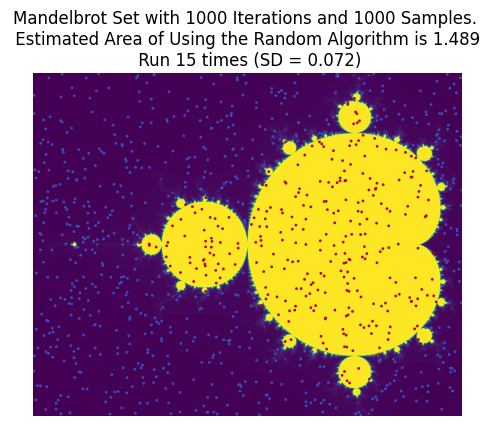

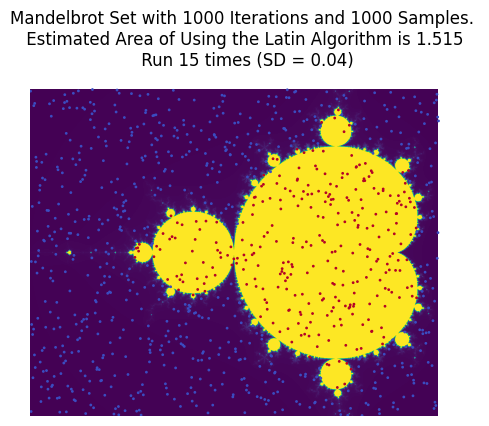

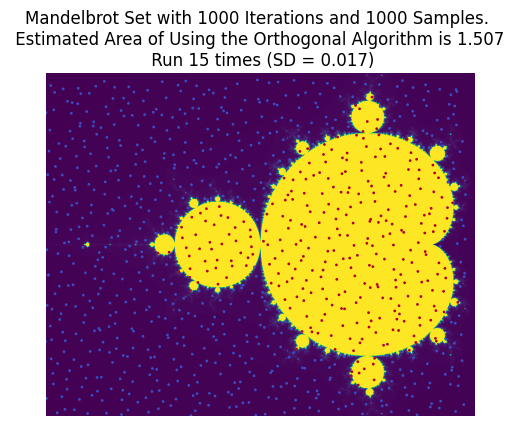

In [27]:
# Define i, s, and number of runs 
number_iterations = [1000]
number_samples = [1000]
number_runs = 15

# Generate graphs of the different sampling methods with different iteration and sample sizes
plot_iterations = run_simulation(number_iterations, number_samples, "Random", c_matrix, numberruns = number_runs, printimage=True)
plot_iterations = run_simulation(number_iterations, number_samples, "Latin", c_matrix, numberruns = number_runs, printimage=True)
plot_iterations = run_simulation(number_iterations, number_samples, "Orthogonal", c_matrix, numberruns = number_runs, printimage=True)

### <font color = Gray> ***Other Plots***</font>

In [37]:
number_iterations = np.linspace(100, 500, 3, dtype=int)
number_samples = np.linspace(100, 5000, 5, dtype=int)
number_runs = 15

In [38]:
type_run = "Random"
plot_iterations = run_simulation(number_iterations, number_samples, type_run, c_matrix, numberruns = number_runs)
true_value = plot_iterations[number_iterations[-1]][-1]
plot_trends(plot_iterations, number_samples, number_runs, type_run)
error_plot_iterations = error_normalize(plot_iterations.copy(), number_iterations)
plot_error(plot_iterations, number_samples, true_value, number_runs, type_run)

IndexError: tuple index out of range

iteration: 100 sample: 100
[0.27, 0.38, 0.39, 0.28, 0.3, 0.39, 0.36, 0.32, 0.41, 0.26, 0.29, 0.32, 0.3, 0.3, 0.28]
iteration: 100 sample: 1325
[0.31471698113207547, 0.3132075471698113, 0.30339622641509434, 0.3373584905660377, 0.3260377358490566, 0.3366037735849057, 0.289811320754717, 0.31018867924528304, 0.3283018867924528, 0.3086792452830189, 0.3177358490566038, 0.31245283018867925, 0.29660377358490564, 0.3154716981132075, 0.28679245283018867]
iteration: 100 sample: 2550
[0.3184313725490196, 0.31098039215686274, 0.30901960784313726, 0.32, 0.31607843137254904, 0.3070588235294118, 0.30980392156862746, 0.3192156862745098, 0.33215686274509804, 0.3050980392156863, 0.29215686274509806, 0.32235294117647056, 0.30392156862745096, 0.2996078431372549, 0.3227450980392157]
iteration: 100 sample: 3775
[0.29880794701986757, 0.3210596026490066, 0.3125827814569536, 0.30993377483443707, 0.31788079470198677, 0.31178807947019865, 0.3165562913907285, 0.2937748344370861, 0.3080794701986755, 0.3128476821192

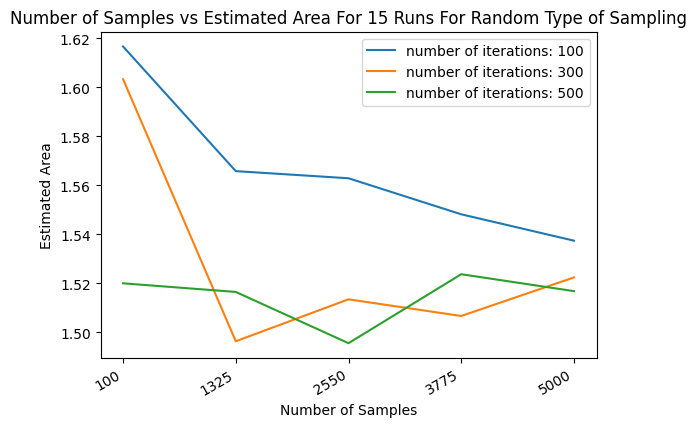

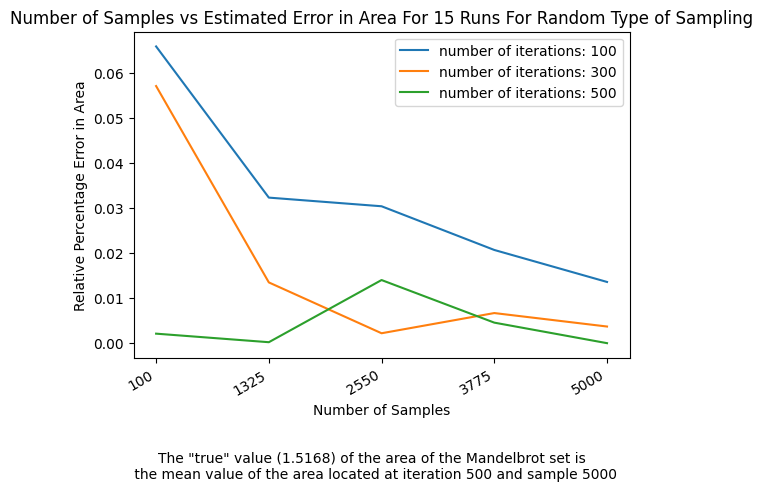

In [ ]:
typee_run = "Latin"
plot_iterations = run_simulation(number_iterations, number_samples, type_run, c_matrix, numberruns = number_runs)
true_value = plot_iterations[number_iterations[-1]][-1]
plot_trends(plot_iterations, number_samples, number_runs, type_run)
error_plot_iterations = error_normalize(plot_iterations.copy(), number_iterations)
plot_error(plot_iterations, number_samples, true_value, number_runs, type_run)

iteration: 100 sample: 100
[0.31, 0.32, 0.29, 0.28, 0.28, 0.32, 0.31, 0.29, 0.29, 0.29, 0.3, 0.32, 0.3, 0.34, 0.29]
iteration: 100 sample: 1325
[0.3086792452830189, 0.3132075471698113, 0.31169811320754715, 0.31169811320754715, 0.30943396226415093, 0.30566037735849055, 0.31245283018867925, 0.3071698113207547, 0.3086792452830189, 0.3049056603773585, 0.3132075471698113, 0.31169811320754715, 0.31169811320754715, 0.3071698113207547, 0.3154716981132075]
iteration: 100 sample: 2550
[0.31098039215686274, 0.307843137254902, 0.31098039215686274, 0.3058823529411765, 0.31254901960784315, 0.3058823529411765, 0.3086274509803922, 0.31058823529411766, 0.31450980392156863, 0.31137254901960787, 0.31098039215686274, 0.307843137254902, 0.30823529411764705, 0.30901960784313726, 0.30901960784313726]
iteration: 100 sample: 3775
[0.311523178807947, 0.3125827814569536, 0.31178807947019865, 0.30834437086092714, 0.3096688741721854, 0.30940397350993376, 0.3101986754966887, 0.30781456953642383, 0.30649006622516556

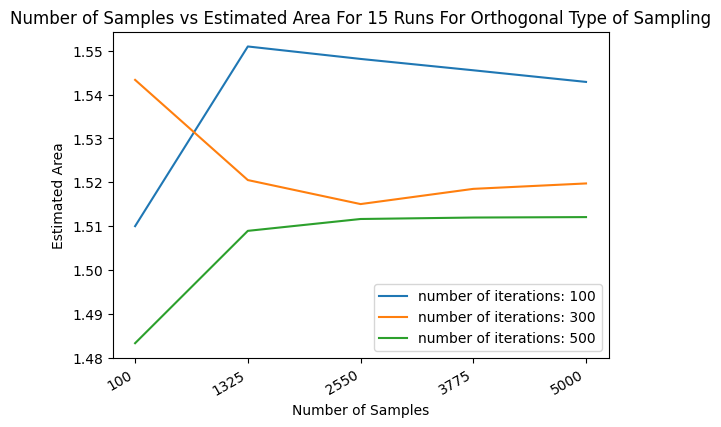

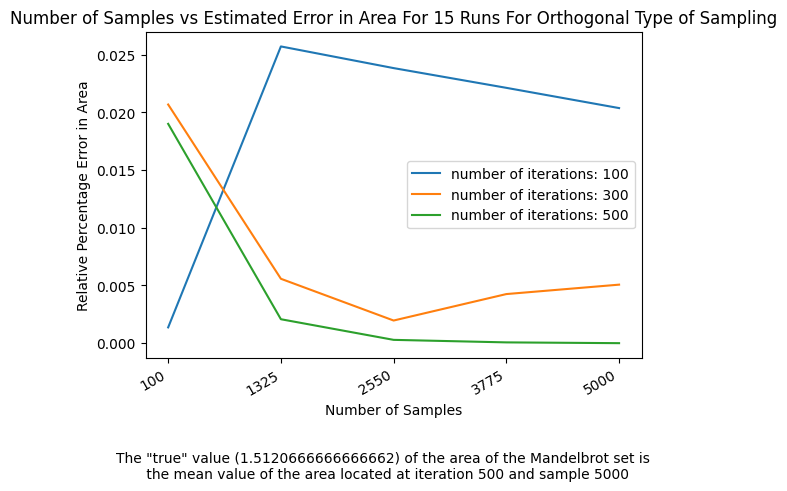

In [ ]:
type_run = "Orthogonal"
plot_iterations = run_simulation(number_iterations, number_samples, type_run, c_matrix, numberruns = number_runs)
true_value = plot_iterations[number_iterations[-1]][-1]
plot_trends(plot_iterations, number_samples, number_runs, type_run)
error_plot_iterations = error_normalize(plot_iterations.copy(), number_iterations)
plot_error(plot_iterations, number_samples, true_value, number_runs, type_run)

### <font color = LightCoral > **Statistical Analysis** </font>

#### <font color = Gray> ***Mean, Standard Deviation and Confidence Interval*** </font>

In [44]:
# Define i, s, and number of runs 
number_iterations = [100]
number_samples = [100]
number_runs = 15

# Generate graphs and collect data for each sampling method
_, data_random, area_random = run_simulation(number_iterations, number_samples, "Random", c_matrix, numberruns=number_runs, printimage=False)
_, data_random, area_random_anti = run_simulation(number_iterations, number_samples, "Random", c_matrix, numberruns=number_runs, printimage=False, antithetic=True)
_, data_latin, area_latin = run_simulation(number_iterations, number_samples, "Latin", c_matrix, numberruns=number_runs, printimage=False)
_, data_orthogonal, area_orthogonal = run_simulation(number_iterations, number_samples, "Orthogonal", c_matrix, numberruns=number_runs, printimage=False)

# Extract standard deviations
stdev_random = [item[4] for item in data_random][-1]
stdev_latin = [item[4] for item in data_latin][-1]
stdev_orthogonal = [item[4] for item in data_orthogonal][-1]

# Extract means
mean_area_random = [item[3] for item in data_random][-1]
mean_area_latin = [item[3] for item in data_latin][-1]
mean_area_orthogonal = [item[3] for item in data_orthogonal][-1]


# Calculate the confidence interval for the first method
confidence_interval_random = stats.t.interval(0.95, number_runs-1, mean_area_random, stdev_random/math.sqrt(number_runs))
print(f"95% Confidence Interval for method 1: {confidence_interval_random}")

# Perform the t-test between the two methods
t_stat, p_value = stats.ttest_ind(area_random, area_latin, equal_var=False)
print(f"T-test between method 1 and method 2: T-statistic = {t_stat}, P-value = {p_value}")

variance_random = variance(area_random)
variance_random_anti = variance(area_random_anti)

ratio_variance = ((variance_random_anti - variance_random)/ variance_random  )*100

print(variance_random)
print(variance_random_anti)
print(ratio_variance)

95% Confidence Interval for method 1: (1.4752327621934223, 1.6714339044732442)
T-test between method 1 and method 2: T-statistic = -0.7075561659037758, P-value = 0.48591301368190765
0.05173809523809523
0.03138095238095237
-39.346525540727114
